In [1]:
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as mp
import time
import pandas as pd
from qutip import *
from numpy import sin, cos, sqrt, array, linspace

### Base on Juan Restrepo's thesis
Title: "Theory of quantum optomechanics with unconventional nonlinear coupling schemes"

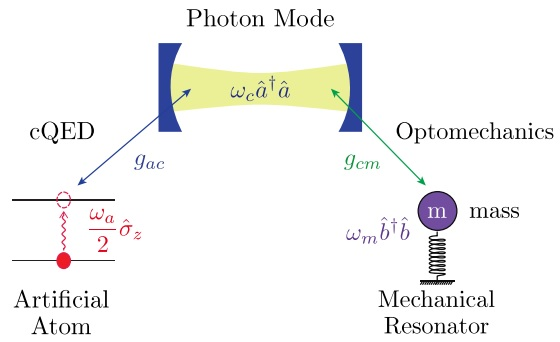

In [8]:
Image(filename='C:/Users/Ahmad/Desktop/2020/photo source/shem2.jpg',width=500, height=400)

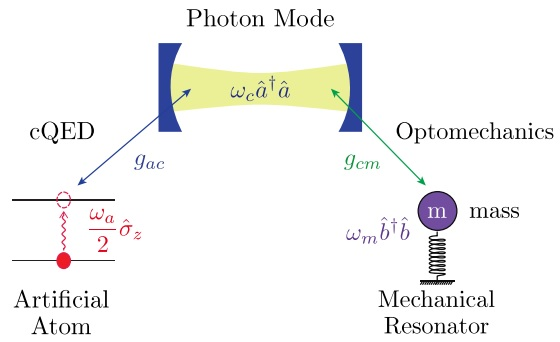

### Hamiltonian For this fully coupled syestem:

$\Large \hat{H}_{0}=\omega_{c}\hat{a}^\dagger \hat{a}+ \frac{\omega_{a}}{2}\hat{\sigma}_{z}+\omega_m \hat{b}^\dagger \hat{b} \\
\Large \;\;\;\;\;\;\;\;\;\;\; ig_{ac}(\hat{\sigma}_{+}\hat{a}-\hat{\sigma}_{-}\hat{a}^\dagger) -
 g_{cm}\hat{a}^\dagger \hat{a}(\hat{b}+\hat{b}^\dagger) $
 

### Coherent optical deriving and dissipation
Dynamics of the open system following Lindblad master equation

$\frac{d\hat{\rho}}{dt}= -i[\hat{H}_{0}+\hat{V}_{p}(t), \hat{\rho}] \\
  \;\;\;\;\;\;\; +\gamma_{c}L[\hat{a}]\hat{\rho}+\gamma_{a}L[\hat{\sigma}_{-}]\hat{\rho} \\
  \;\;\;\;\;\;\; +n_{th}\gamma_{m}L[\hat{b}^\dagger]
  +(n_{th}+1)\gamma_{m} L[\hat{b}]\hat{\rho}$

Which $\gamma_{m}$,$\gamma_{c}$ and $\gamma_{a}$ are the mechanical, cavity, and atomic
loss rates. $n_{th}$ is the thermal mean phonon occupancy. 

$\hat{V}_{p}(t)$ is coherent optical derive with frequency $\omega_{p}$ and amplitude $F_p$

$\hat{V}_{p}(t)= iF_p (\hat{a}^\dagger e^{i\omega_p t}-\hat{a} e^{-i\omega_p t})$

in order to remove t-dependence of H, we move to the rotating frame via unitary transformation...
Eventually, this is a H:

$ \hat{H}_{0}=\Delta_{cp}\hat{a}^\dagger \hat{a}+ \Delta_{ap}\hat{\sigma}_{z}+\omega_m \hat{b}^\dagger \hat{b} \\
 \;\;\;\;\;\;\; +ig_{ac}(\hat{\sigma}_{+}\hat{a}-\hat{\sigma}_{-}\hat{a}^\dagger) -
 g_{cm}\hat{a}^\dagger \hat{a}(\hat{b}+\hat{b}^\dagger) \\
\;\;\;\;\;\;\; + iF_p (\hat{a}^\dagger -\hat{a} ) $


## Photon number
Time evolution of photon and phonon 
Aim to find result similar to following Figure 

Fig IV.14 pg(101)

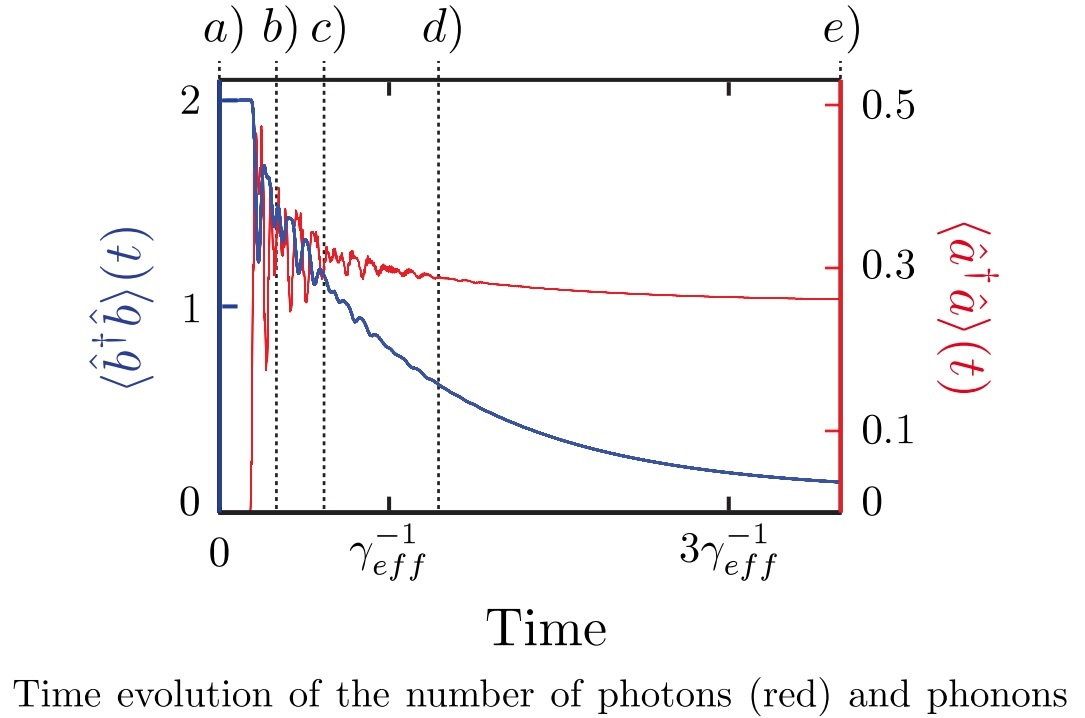

In [101]:
Image(filename='C:/Users/Ahmad/Desktop/2020/Python/SinglePolaritonOptomechanics_corr_photNum_07.07.2020/thesis1.jpg'\
      ,width=550, height=450)

In [1]:
# parameter values
n_th= 0 # 2.15 # 3.45               # thermal mean phonon occupancy
wm = 1.0                   #  mechanical frequency
wc = 100 * wm                  # cavity frequency.... 
wa = wc                      # resonance case

gamma_m = wm * 1e-4            # mechanical loss
gamma_a = wc * 1e-4
gamma_c = gamma_a

g_ac = wm/2.0               # atom-cavity coupling strength
g_cm = 0.1 * wm               # cavity-resonator coupling
g_am = 0.0               # atom-resonator coupling

F_p = gamma_c * 1.0 * sqrt(2)   # laser amplitude

delta_ac = wa - wc        # atom-cavity detuning 
omega_p = wc/2.0 + g_ac       # eigenenergies for atom-cavity subsystem
omega_m = wc/2.0 -  g_ac      # for case which n=1

#omega_m = wc/2.0 -  g_ac
wp = omega_m  # - wm             # laser frequency

delta_cp = wc - wp        # cavity-driving detuning
delta_ap = (wa - wp) # * 0.5        # atom-driving detuning   or wa/2 ?
delta_mp = wm - wp             # ??

gamma_eff = 18 * gamma_m   # the number of phonons steadily decreases with an effective dissipation const


1/gamma_eff

555.5555555555555

In [115]:
Pars = {"$ \omega_c$": [wc],"$ \omega_a$": [wa],"$ \omega_m$": [wm],"$ g_{ac} /\omega_m$": [g_ac/wm],\
        "$\gamma_a/\omega_m$" : [gamma_a/wm],\
        "$g_{cm}/\omega_m$" : [g_cm/wm],"$Q_m$" : [wm/gamma_m],"$Q_c$":[wc/gamma_c],"$Q_a$" : [wa/gamma_a],\
        "$F_p/\gamma_a$" : [F_p/gamma_c],"$ \omega_{+}$": [omega_p],"$ \omega_{-}$": [omega_m],"$ \omega_p$": [wp]}
dataa = pd.DataFrame(Pars)
dataa

,$ \omega_c$,$ \omega_a$,$ \omega_m$,$ g_{ac} /\omega_m$,$\gamma_a/\omega_m$,$g_{cm}/\omega_m$,$Q_m$,$Q_c$,$Q_a$,$F_p/\gamma_a$,$ \omega_{+}$,$ \omega_{-}$,$ \omega_p$
0,100.0,100.0,1.0,0.5,0.01,0.1,10000.0,10000.0,10000.0,14.142136,50.5,49.5,49.5


### All the values that are used for this simulation base on above table

In [117]:
Nc = 8     # cavity photon number
Nm = 8    # mechanical phonon number 

a = tensor(qeye(2), qeye(Nm),destroy(Nc))     # cavity anihilation operator
b = tensor(qeye(2), destroy(Nm),qeye(Nc))      # phonon anihilation opr

sigma_z = tensor(sigmaz(), qeye(Nm), qeye(Nc))
sigma_p = tensor(sigmap(), qeye(Nm), qeye(Nc))  # raising and lowering ops for atom
sigma_m = tensor(sigmam(), qeye(Nm), qeye(Nc))
    
collapse = []


rate = gamma_c
if rate > 0.0: 
    collapse.append(a * sqrt(rate))
rate = gamma_a
if rate > 0.0 : 
    collapse.append(sigma_m * sqrt(rate))
rate = n_th * gamma_m
if rate > 0.0: 
    collapse.append(b.dag() * sqrt(rate))
rate = (n_th+1) * gamma_m
if rate > 0.0 : 
    collapse.append(b * sqrt(rate))

expct_ops = []
expct_ops.append(a.dag()*a)
expct_ops.append(b.dag()*b)

# defining H as a function of atom-phonon coupling --->> g_am
#g_amlist = np.linspace(0.25,0.75,30) * g_cm         # g_am range 
    
H = (wc-wp) * a.dag() * a + 0.5 * (wa-wp) *sigma_z + (wm) * b.dag() * b \
+ 1j * g_ac * (sigma_p * a - sigma_m * a.dag()) - g_cm * a.dag() * a *(b.dag() + b) \
+ 1j* F_p *(a.dag()-a)
    
#rho_ss = steadystate(H, collapse)           # final state for steady state
#bdagb.append(expect(b.dag()* b, rho_ss))    # calculate expectation of b.dag*b for steady state 

#g20.append(expect(b.dag()* b.dag()* b * b, rho_ss)/expect (b.dag()*b,rho_ss)**2)
#(collapse[3])

In [118]:
psi0 = tensor(basis(2,0),basis(Nm,2),basis(Nc,0));
times = np.linspace(0.0, 450,1000)   # 3/gamma_eff
opt=Options(nsteps=8000)
output = mesolve(H, psi0, times,collapse,expct_ops,options=opt)

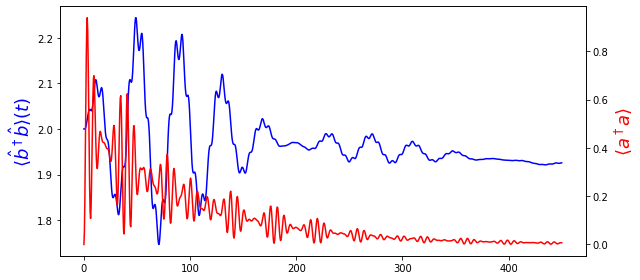

In [124]:
# n_th= 0 
# F_p = 10 *sqrt(2)* gamma_a
fig, ax1= plt.subplots(figsize=(9,4))

ax2 = ax1.twinx()    # instantiate a second axes that shares the same x-axis
ax1.plot(times,output.expect[1],'b')
ax2.plot(times ,output.expect[0],'r')

ax1.set_ylabel(r'$\langle \hat{b}^\dagger \hat{b} \rangle(t)$',fontsize=18,color='blue')
ax2.set_ylabel(r'$\langle a^\dagger a \rangle$',fontsize=18,color='red')
#ax1.set_ylim([0,2])
#ax1.set_ylim([1.3,2.25])
fig.tight_layout()  # otherwise the right y-label is slightly clipped

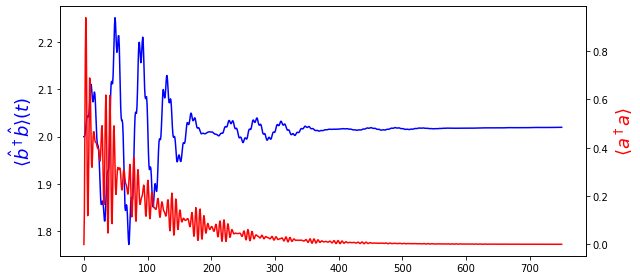

In [61]:
# n_th= 2.45 
# F_p = 100* gamma_a
fig, ax1= plt.subplots(figsize=(9,4))

ax2 = ax1.twinx()    # instantiate a second axes that shares the same x-axis
ax1.plot(times,output.expect[1],'b')
ax2.plot(times ,output.expect[0],'r')

ax1.set_ylabel(r'$\langle \hat{b}^\dagger \hat{b} \rangle(t)$',fontsize=18,color='blue')
ax2.set_ylabel(r'$\langle a^\dagger a \rangle$',fontsize=18,color='red')
#ax1.set_ylim([0,2])
#ax2.set_ylim([0,2.25])
fig.tight_layout()  # otherwise the right y-label is slightly clipped

steady state
$\langle b^\dagger b \rangle$


In [ ]:
omega_m-wm